In [87]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Viz with Plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
train_df = pd.read_csv('flight_delays_train.csv')

In [89]:
train_df.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [90]:
test_df = pd.read_csv('flight_delays_test.csv')

In [91]:
test_df.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0   c-7       c-25       c-3      615            YV    MRY  PHX       598
1   c-4       c-17       c-2      739            WN    LAS  HOU      1235
2  c-12        c-2       c-7      651            MQ    GSP  ORD       577
3   c-3       c-25       c-7     1614            WN    BWI  MHT       377
4   c-6        c-6       c-3     1505            UA    ORD  STL       258

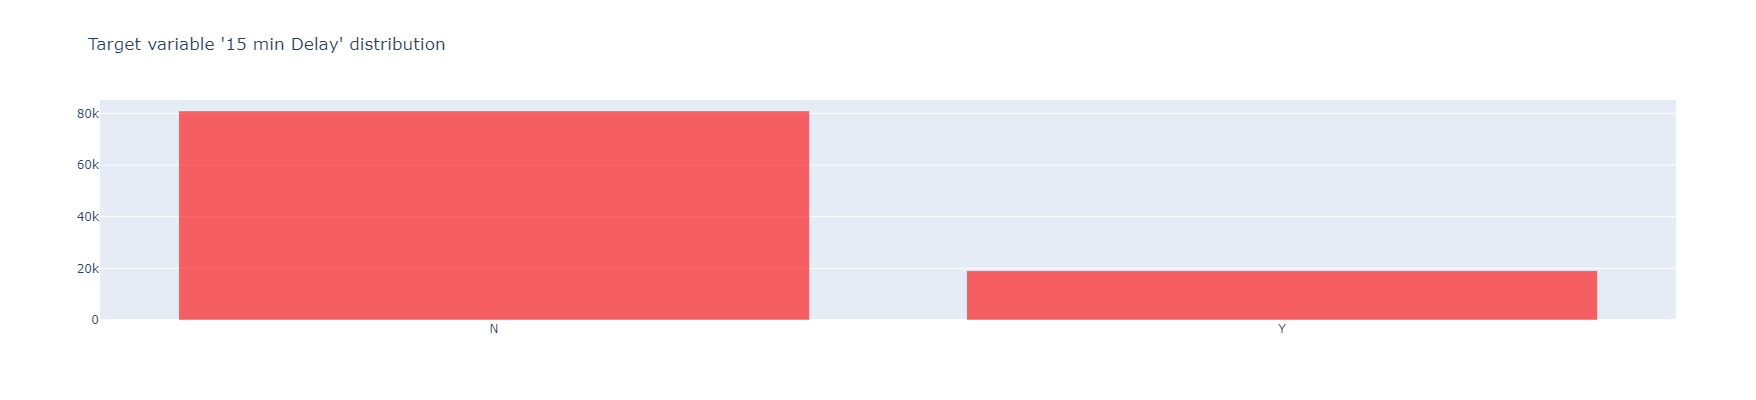

In [92]:
# Check the target variable dep_delayed_15min
trace = [go.Bar(
            x = train_df['dep_delayed_15min'].value_counts().index.values,
            y = train_df['dep_delayed_15min'].value_counts().values,
            marker = dict(color='red', opacity=0.6)
    )]


layout = dict(title="Target variable '15 min Delay' distribution", 
              margin=dict(l=100), 
              width=400, 
              height=400)

fig = go.Figure(data=trace, layout=layout)

iplot(fig)

The target 15 mins delay(Y) has around 20k rows.

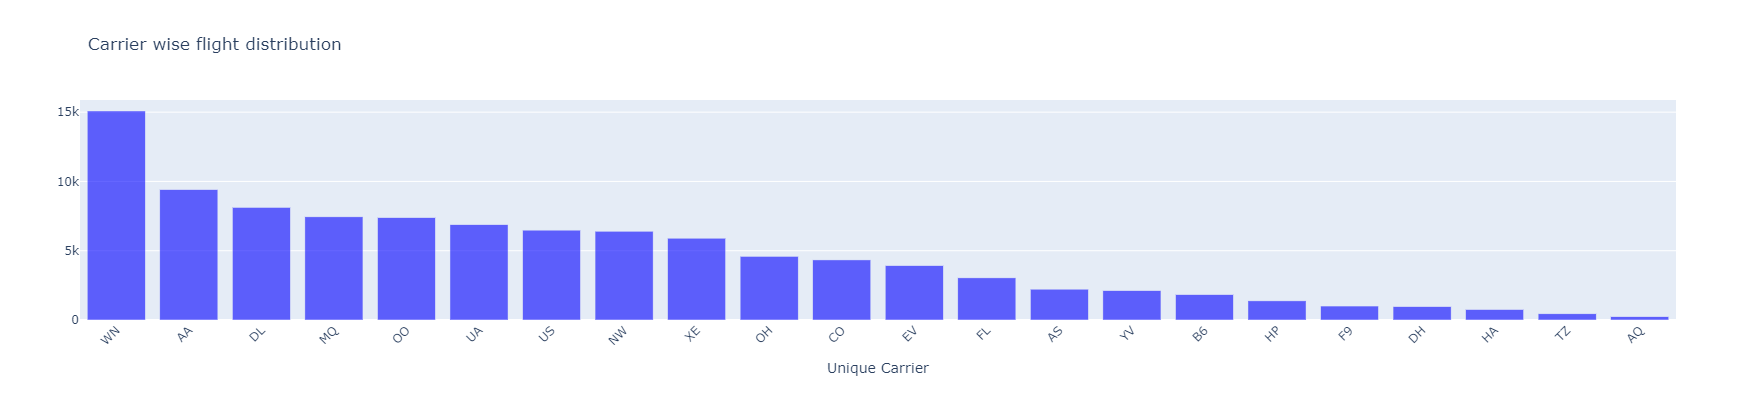

In [93]:
# Plot the UniqueCarrier wise frequency of flights
trace = [go.Bar(
            x = train_df['UniqueCarrier'].value_counts().index.values,
            y = train_df['UniqueCarrier'].value_counts().values,
            marker = dict(color='blue', opacity=0.6)
    )]


layout = dict(title="Carrier wise flight distribution", 
              width=800, 
              height=400,
                 xaxis=dict(title='Unique Carrier',tickmode='linear',tickangle=-45))

fig = go.Figure(data=trace, layout=layout)

iplot(fig)

There is lot of difference between the head and tail in the frequencies. If we plan to use this variable in our model, potentiialy we can see if we can merger a few of them together.

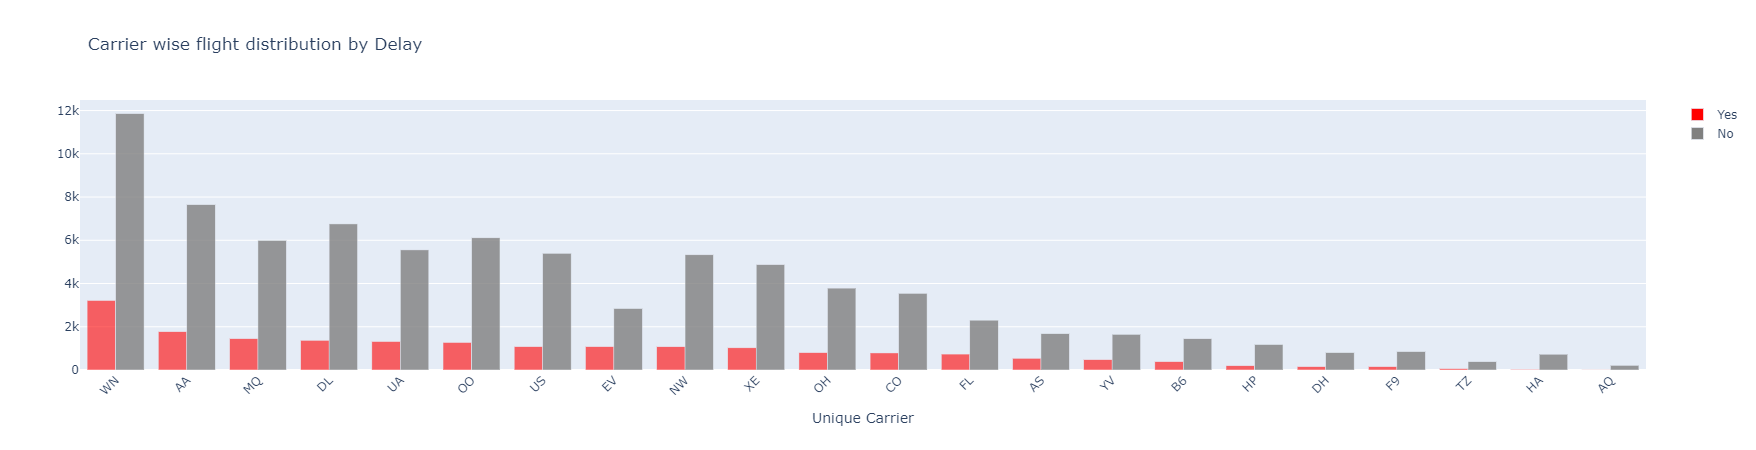

In [94]:
# Plot UniqueCarrier and Delay
trace1 = go.Bar(
            x = train_df[train_df['dep_delayed_15min'] == 'Y']['UniqueCarrier'].value_counts().index.values,
            y = train_df[train_df['dep_delayed_15min'] == 'Y']['UniqueCarrier'].value_counts().values,
            name='Yes',
            marker=dict(color='red',opacity=0.6)
)
trace2 = go.Bar(
            x = train_df[train_df['dep_delayed_15min'] == 'N']['UniqueCarrier'].value_counts().index.values,
            y = train_df[train_df['dep_delayed_15min'] == 'N']['UniqueCarrier'].value_counts().values,
            name='No',
            marker=dict(color='grey',opacity=0.8)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Carrier wise flight distribution by Delay",
    xaxis=dict(title='Unique Carrier',tickangle=-45),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

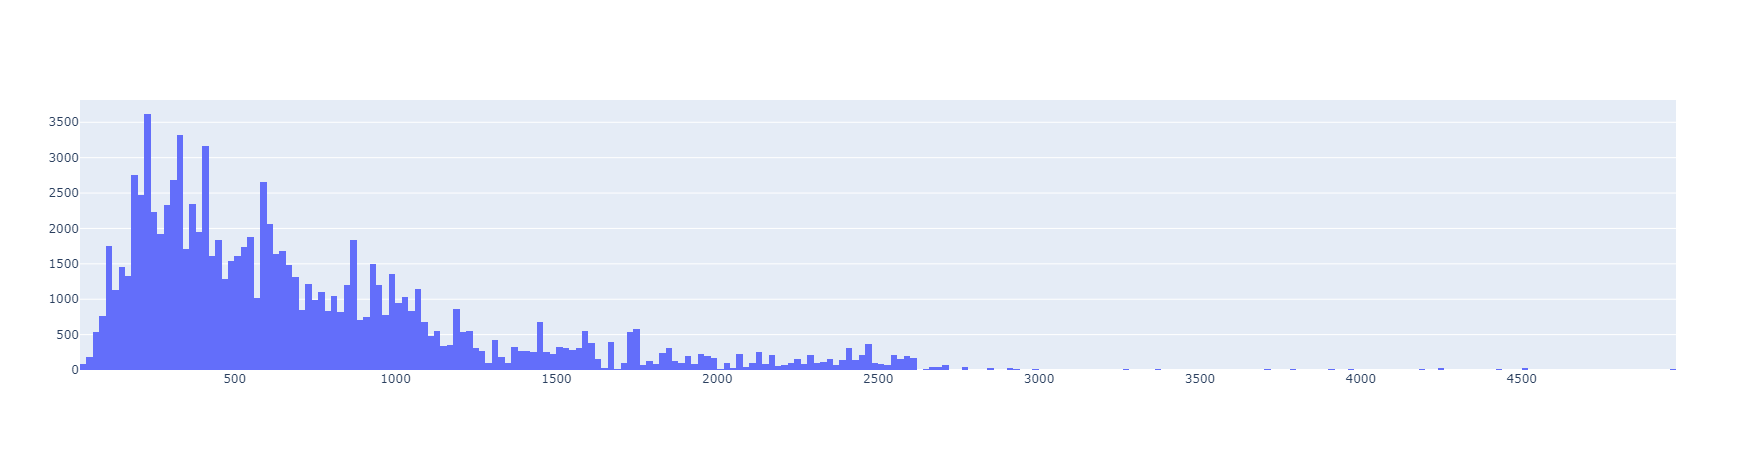

In [95]:
# Plot the Distance variable
data = [go.Histogram(x=train_df['Distance'])]
iplot(data)

There are quite a few outliers.

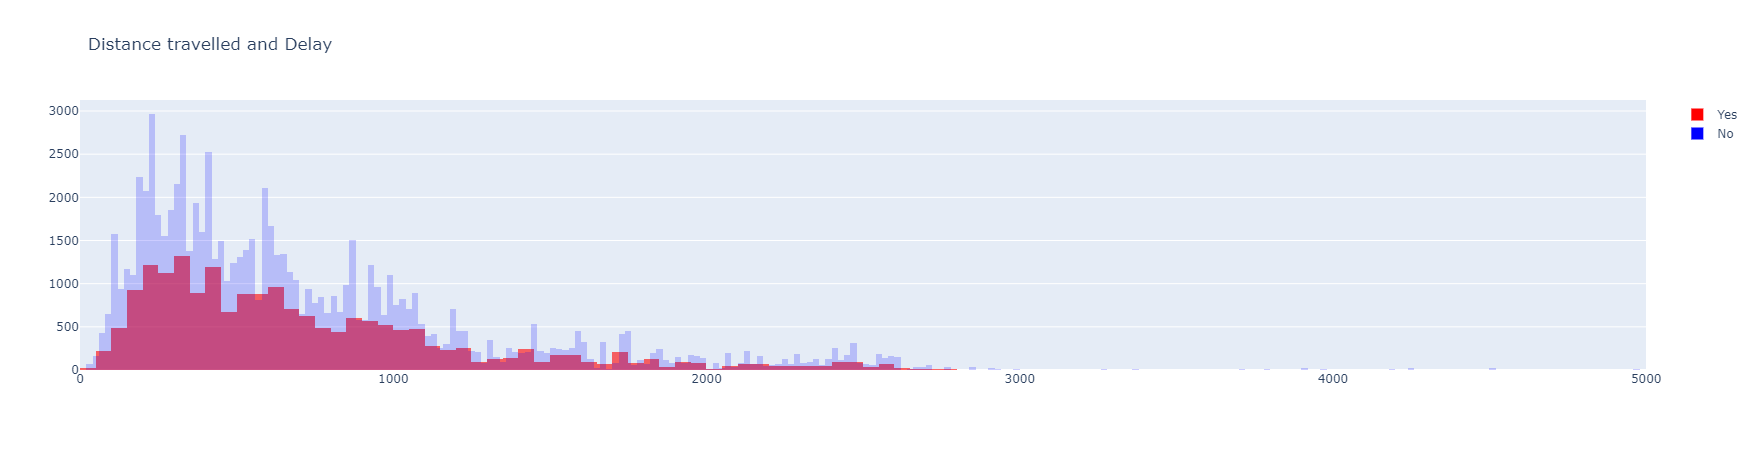

In [96]:
# Plot the histogram of Distance with Delay
trace1 = go.Histogram(
    x=train_df[train_df['dep_delayed_15min'] == 'Y']['Distance'],
    name='Yes',
    marker=dict(color='red',opacity=0.6)
)
trace2 = go.Histogram(
    x=train_df[train_df['dep_delayed_15min'] == 'N']['Distance'],
    name='No',
    marker=dict(color='blue',opacity=0.2)
)

data = [trace1, trace2]
layout = go.Layout(title="Distance travelled and Delay",
                   barmode='overlay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Observe less delays in long distance flights.

**Create new features**

In [97]:
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    train_df[col] = train_df[col].apply(lambda x: x.split('-')[1]).astype(np.int32) - 1

for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    test_df[col] = test_df[col].apply(lambda x: x.split('-')[1]).astype(np.int32) - 1

In [98]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

train_df['hour'] = train_df['DepTime'] // 100
train_df.loc[train_df['hour'] == 24, 'hour'] = 0
train_df.loc[train_df['hour'] == 25, 'hour'] = 1
train_df['minute'] = train_df['DepTime'] % 100
test_df['hour'] = test_df['DepTime'] // 100
test_df.loc[test_df['hour'] == 24, 'hour'] = 0
test_df.loc[test_df['hour'] == 25, 'hour'] = 1
test_df['minute'] = test_df['DepTime'] % 100

train_df['UniqueCarrier_x'] = ((train_df['UniqueCarrier'].isin(['EV','WN', 'MQ']))).astype('str')
test_df['UniqueCarrier_x'] = ((test_df['UniqueCarrier'].isin(['EV', 'WN', 'MQ']))).astype('str')

train_df['Origin_x'] = ((train_df['Origin'].isin(['ATL', 'EWR', 'ORD', 'MDW', 'PHL']))).astype('str')
test_df['Origin_x'] = ((test_df['Origin'].isin(['ATL', 'EWR', 'ORD', 'MDW', 'PHL']))).astype('str')

train_df['Dest_x'] = ((train_df['Dest'].isin(['EWR', 'ATL', 'LGA', 'ORD']))).astype('str')
test_df['Dest_x'] = ((test_df['Dest'].isin(['EWR', 'ATL', 'LGA', 'ORD']))).astype('str')

train_df['month_x'] = ((train_df['Month'].isin([6, 7, 12]))).astype('str')
test_df['month_x'] = ((test_df['Month'].isin([6, 7, 12]))).astype('str')

train_df['DayOfWeek_x'] = ((train_df['DayOfWeek'].isin([4, 5]))).astype('str')
test_df['DayOfWeek_x'] = ((test_df['DayOfWeek'].isin([4, 5]))).astype('str')

train_df['DayofMonth_x'] = ((train_df['DayofMonth'] >= 15) & (train_df['DayofMonth'] < 28)).astype('str')
test_df['DayofMonth_x'] = ((test_df['DayofMonth'] >= 15) & (test_df['DayofMonth'] < 28)).astype('str')

In [99]:
df_t = pd.crosstab(train_df.hour,train_df.dep_delayed_15min)
df_t.head()

dep_delayed_15min    N    Y
hour                       
0                  145  186
1                   30   52
2                   15   12
3                    3    5
4                   35    3

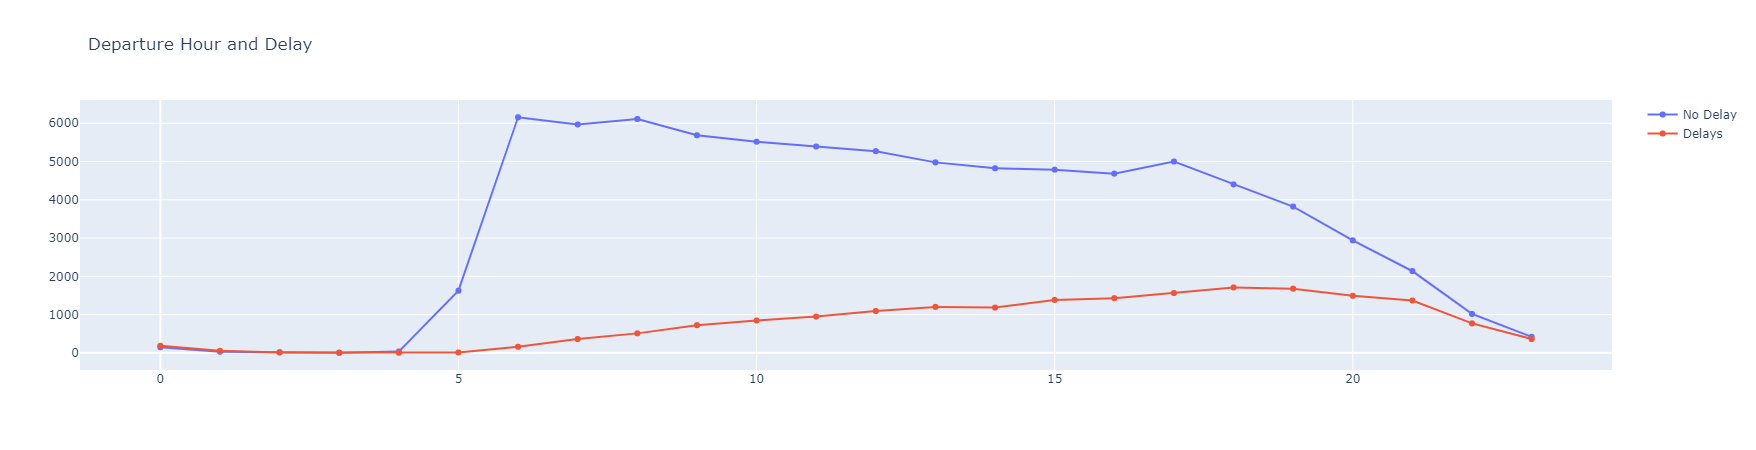

In [100]:
# Plot the departure hour and the delay
trace0 = go.Scatter(
    x = df_t.index,
    y = df_t['N'],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = df_t.index,
    y = df_t['Y'],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Departure Hour and Delay")

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [101]:
train_df['minute'] = train_df['minute'].astype(str) 
test_df['minute'] = test_df['minute'].astype(str) 

train_df['minute'] = np.where(train_df['minute'].str.len() < 2, '0' + train_df['minute'], train_df['minute'])
train_df['minute'] = train_df['minute'].str[:1]
test_df['minute'] = np.where(test_df['minute'].str.len() < 2, '0' + test_df['minute'], test_df['minute'])
test_df['minute'] = test_df['minute'].str[:1]

In [102]:
# Changing types
train_df['hour'] = train_df['hour'].astype(str) 
test_df['hour'] = test_df['hour'].astype(str) 
train_df['Month'] = train_df['Month'].astype(str) 
test_df['Month'] = test_df['Month'].astype(str) 
train_df['DayOfWeek'] = train_df['DayOfWeek'].astype(str) 
test_df['DayOfWeek'] = test_df['DayOfWeek'].astype(str) 
train_df['DayofMonth'] = train_df['DayofMonth'].astype(str) 
test_df['DayofMonth'] = test_df['DayofMonth'].astype(str) 

In [103]:
# Adding more new features
train_df['Origin_Dest_Uniq'] = train_df['Origin_x'] + '-->' +train_df['Dest_x'] + '-->' +train_df['UniqueCarrier_x']
test_df['Origin_Dest_Uniq'] = test_df['Origin_x'] + '-->' +test_df['Dest_x'] + '-->' +test_df['UniqueCarrier_x']

train_df['Origin_hours'] = train_df['Origin_x'] + '-->' +train_df['hour']
test_df['Origin_hours'] = test_df['Origin_x'] + '-->' +test_df['hour']

train_df['Origin_uniqueCarrier'] = train_df['Origin_x'] + '-->' +train_df['UniqueCarrier_x']
test_df['Origin_uniqueCarrier'] = test_df['Origin_x'] + '-->' +test_df['UniqueCarrier_x']

In [104]:
# Throw out similar features 
train_df = train_df.drop('Origin_x', axis=1)
train_df = train_df.drop('Dest_x', axis=1)
train_df = train_df.drop('UniqueCarrier_x', axis=1)
train_df = train_df.drop('month_x', axis=1)
train_df = train_df.drop('DayOfWeek_x', axis=1)
train_df = train_df.drop('DepTime', axis=1)

test_df = test_df.drop('Origin_x', axis=1)
test_df = test_df.drop('Dest_x', axis=1)
test_df = test_df.drop('UniqueCarrier_x', axis=1)
test_df = test_df.drop('month_x', axis=1)
test_df = test_df.drop('DayOfWeek_x', axis=1)
test_df = test_df.drop('DepTime', axis=1)

In [105]:
train_df.head()

Month DayofMonth DayOfWeek UniqueCarrier Origin Dest  Distance  \
0     7         20         6            AA    ATL  DFW       732   
1     3         19         2            US    PIT  MCO       834   
2     8          1         4            XE    RDU  CLE       416   
3    10         24         5            OO    DEN  MEM       872   
4     9          6         5            WN    MDW  OMA       423   

  dep_delayed_15min     flight hour minute DayofMonth_x  \
0                 N  ATL-->DFW   19      3         True   
1                 N  PIT-->MCO   15      4         True   
2                 N  RDU-->CLE   14      2        False   
3                 N  DEN-->MEM   10      1         True   
4                 Y  MDW-->OMA   18      2        False   

        Origin_Dest_Uniq Origin_hours Origin_uniqueCarrier  
0   True-->False-->False    True-->19         True-->False  
1  False-->False-->False   False-->15        False-->False  
2  False-->False-->False   False-->14        False-->False  
3  False-->False-->False   False-->10        False-->False  
4    True-->False-->True    True-->18          True-->True

In [106]:
train_df.dtypes

Month                   object
DayofMonth              object
DayOfWeek               object
UniqueCarrier           object
Origin                  object
Dest                    object
Distance                 int64
dep_delayed_15min       object
flight                  object
hour                    object
minute                  object
DayofMonth_x            object
Origin_Dest_Uniq        object
Origin_hours            object
Origin_uniqueCarrier    object
dtype: object

**Remember indexes of categorical features (to be passed to CatBoost)**

In [107]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

**Allocate a hold-out set (a.k.a. a validation set) to validate the model**

In [108]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [109]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [110]:
ctb = CatBoostClassifier(task_type="GPU", random_seed=17, silent=True)

In [111]:
%%time
ctb.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);

Wall time: 1min 1s


In [112]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

**We got some 0.806 ROC AUC on the hold-out set.**

In [113]:
roc_auc_score(y_valid, ctb_valid_pred)

0.8060379148002353

**Train on the whole train set, make prediction on the test set.**

In [114]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

Wall time: 1min 5s


In [115]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [116]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('flight_delay_ctb.csv')